In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [2]:
import math
import random
import os
import evaluate
from tqdm import tqdm


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import BertTokenizer, BertForSequenceClassification, BartForConditionalGeneration, BartTokenizer, TrainingArguments, Trainer
from datasets import Dataset
import torch

import spacy
from spacy.lang.en import STOP_WORDS

from imblearn.under_sampling import RandomUnderSampler

In [3]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [4]:
df = pd.read_csv('../input/amazon-books-reviews/Books_rating.csv')

In [5]:
df.columns

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')

In [6]:
df = df.dropna(subset=['review/summary', 'review/score'])

In [7]:
df.size

29995930

In [8]:
combined_reviews = df.groupby('Title').agg(
    combined_review = ('review/summary', '.'.join),  # Concatenate all review summaries
    avg_rating = ('review/score', 'mean'),  # Calculate the average rating
    review_count=('review/summary', 'count') # Number of reviews for each book
).reset_index()

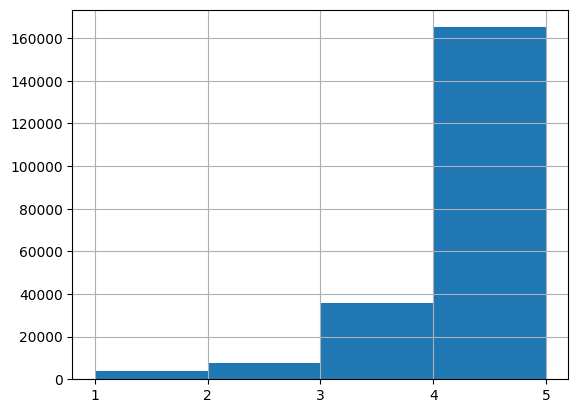

In [9]:
import matplotlib.pyplot as plt
combined_reviews['avg_rating'].hist(bins = [1, 2, 3, 4, 5])
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [10]:
combined_reviews['review_class'] = combined_reviews['avg_rating'].apply(lambda x: math.ceil(x))
combined_reviews.loc[combined_reviews['review_class'] == 1, 'review_class'] = 2

combined_reviews = combined_reviews[combined_reviews['review_count'] >= 3]

In [11]:
# Since data is imbalanced, use stratified split
seg_df, rest_df = train_test_split(combined_reviews, train_size=0.4, random_state=24, stratify = combined_reviews['review_class'])
_, test_df = train_test_split(rest_df, test_size=0.02, random_state=24, stratify = rest_df['review_class'])

In [12]:
seg_df['review_class'].value_counts()

review_class
5    30877
4    12121
3     2305
2      362
Name: count, dtype: int64

In [13]:
combined_reviews.size

570820

In [14]:
test_df['review_class'].value_counts()

review_class
5    926
4    364
3     69
2     11
Name: count, dtype: int64

In [15]:
under_sampler = RandomUnderSampler(random_state = 42)
seg_df_balnced, _ = under_sampler.fit_resample(seg_df, seg_df['review_class'])

test_df_balnced, _ = under_sampler.fit_resample(test_df, test_df['review_class'])

In [16]:
seg_df_balnced['review_class'].value_counts()

review_class
2    362
3    362
4    362
5    362
Name: count, dtype: int64

In [17]:
test_df_balnced['review_class'].value_counts()

review_class
2    11
3    11
4    11
5    11
Name: count, dtype: int64

In [18]:
# Create a TF-IDF Vectorizer and fit_transform the sentences
vectorizer = TfidfVectorizer(stop_words='english', min_df=1)
def compute_cosine_similarity(sentences, review):
    tfidf_matrix = vectorizer.fit_transform(sentences + [review])  # Add review to the end of the sentences list
    
    # Compute cosine similarity between each sentence and the review (last item)
    cosine_sim = cosine_similarity(tfidf_matrix[:-1], tfidf_matrix[-1])  # Compare all sentences with the review
    
    return cosine_sim.flatten()

In [19]:
# Load our trained tokenizer and model
bert_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_sentiment(sentence):
   sentiment_labels = ["negative", "negative","neutral", "positive", "positive"]
   inputs = bert_tokenizer.encode_plus(
        sentence,
        max_length = 512,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'pt',
        add_special_tokens = True
    ).to(device)

   with torch.no_grad():
       outputs = bert_model(**inputs)
       logits = outputs.logits
   prediction = torch.argmax(logits, dim=-1).item()
   sentiment = sentiment_labels[prediction]
   return sentiment

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [20]:
import re

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", disable=["ner"])

def get_sentences(sentence):
    # Tokenize the entire document
    doc = nlp(sentence)
    sentences = [sent.text for sent in doc.sents if sent.text.strip()]

    # Remove stopwords and non-alphabetic words
    cleaned_sentences = []
    for sent in sentences:
        cleaned_sentences.append(" ".join([token.text for token in nlp(sent) if token.text.lower() not in STOP_WORDS and len(token.text) > 2]))

    # Remove repeating dots and other repetitive punctuation
    cleaned_sentences = [
        re.sub(r'([.!?])\1+', r'\1', re.sub(r'\.{3,}', '.', sent)) for sent in cleaned_sentences
    ]

    return cleaned_sentences



In [21]:
def create_synthetic_summaries(review, n_top):
    sentences = get_sentences(review)
    if not sentences:
      return ""

    sentiments = [get_sentiment(sentence) for sentence in sentences]

    # Group sentences by sentiment type
    pos_sentences = [sentence for sentence, sentiment in zip(sentences, sentiments) if sentiment == 'positive']
    neg_sentences = [sentence for sentence, sentiment in zip(sentences, sentiments) if sentiment == 'negative']
    neu_sentences = [sentence for sentence, sentiment in zip(sentences, sentiments) if sentiment == 'neutral']

    # Compute cosine similarity between all sentences
    cosine_sim = compute_cosine_similarity(sentences, review)

    # Calculate the number of sentences to select from each sentiment category
    total_sentences = len(sentences)
    pos_count = len(pos_sentences)
    neg_count = len(neg_sentences)
    neu_count = len(neu_sentences)

    # Calculate the number of sentences to select based on the proportions
    pos_ratio = pos_count / total_sentences
    neg_ratio = neg_count / total_sentences
    neu_ratio = neu_count / total_sentences

    num_pos = max(1, int(n_top * pos_ratio))  # At least 1 sentence
    num_neg = max(1, int(n_top * neg_ratio))  # At least 1 sentence
    num_neu = max(1, int(n_top * neu_ratio))  # At least 1 sentence

    # Get cosine similarity scores for each sentence (sum of similarities with others)
    sentence_scores = cosine_sim

    # Select sentences from each sentiment category based on similarity scores
    selected_sentences = []

    # Select from Positive Sentences
    if num_pos > 0:
        pos_indices = [i for i, sentiment in enumerate(sentiments) if sentiment == 'positive']
        pos_scores = [(i, sentence_scores[i]) for i in pos_indices]
        pos_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity score dec so we get text relvant to review
        selected_sentences.extend([sentences[i] for i, _ in pos_scores[:num_pos]])

    # Select from Negative Sentences
    if num_neg > 0:
        neg_indices = [i for i, sentiment in enumerate(sentiments) if sentiment == 'negative']
        neg_scores = [(i, sentence_scores[i]) for i in neg_indices]
        neg_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity score
        selected_sentences.extend([sentences[i] for i, _ in neg_scores[:num_neg]])

    # Select from Neutral Sentences
    if num_neu > 0:
        neu_indices = [i for i, sentiment in enumerate(sentiments) if sentiment == 'neutral']
        neu_scores = [(i, sentence_scores[i]) for i in neu_indices]
        neu_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity score
        selected_sentences.extend([sentences[i] for i, _ in neu_scores[:num_neu]])

    return ' '.join(selected_sentences[:])

In [22]:
tqdm.pandas(desc = "Generating Synthetic Summaries ...")

In [23]:
seg_df_balnced['synthetic_summary'] = seg_df_balnced['combined_review'].progress_apply(lambda long_summary: create_synthetic_summaries(long_summary, 5))

Generating Synthetic Summaries ...: 100%|██████████| 1448/1448 [14:43<00:00,  1.64it/s]  


In [24]:
seg_train_df, seg_test_df = train_test_split(seg_df_balnced, train_size=0.8, random_state=24)

In [25]:
# Load pre-trained BART model and tokenizer
bart_model_name = "facebook/bart-large-cnn"
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name)
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)

bart_model.to(device)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    

In [26]:
train_dataset = Dataset.from_pandas(seg_train_df)
eval_dataset = Dataset.from_pandas(seg_test_df)

In [27]:
def tokenize(record):
    # Tokenize inputs (combined review) as a batch
    inputs = record['combined_review']
    targets =record['synthetic_summary']

    # Tokenize the inputs for the batch
    model_inputs = bart_tokenizer(inputs, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")

    # Tokenize the targets (synthetic summaries) as a batch
    labels = bart_tokenizer(targets, max_length=150, truncation=True, padding="max_length", return_tensors="pt")

    # Add labels to model_inputs dictionary
    model_inputs['labels'] = labels['input_ids']

    return model_inputs


In [28]:
train = train_dataset.map(tokenize, batched = True)
eval =  eval_dataset.map(tokenize,  batched = True)

Map:   0%|          | 0/1158 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

In [29]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode predictions and labels

    decoded_preds = bart_tokenizer.decode(predictions, skip_special_tokens=True)
    decoded_labels = bart_tokenizer.decode(labels, skip_special_tokens=True)
    # Load accuracy metric
    accuracy_metric = evaluate.load("accuracy")

    # Compute Accuracy
    accuracy_result = accuracy_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Return the accuracy result
    result = {
        "accuracy": accuracy_result
    }

    return result


In [30]:
training_args = TrainingArguments(
    output_dir = './results',
    report_to="none",
    eval_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    num_train_epochs = 3,
    weight_decay = 0.01,
    warmup_steps = 200,
    save_strategy="epoch",              
    load_best_model_at_end=True
)

In [31]:
trainer = Trainer(
    model = bart_model,
    args = training_args,
    train_dataset = train,
    eval_dataset = eval
    #compute_metrics = compute_metrics
)

In [32]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.250152
2,No log,0.138673
3,No log,0.130728


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked t

TrainOutput(global_step=435, training_loss=1.282611434761135, metrics={'train_runtime': 1178.2585, 'train_samples_per_second': 2.948, 'train_steps_per_second': 0.369, 'total_flos': 7528521387737088.0, 'train_loss': 1.282611434761135, 'epoch': 3.0})

In [33]:
test_reviews = [
    "The book had its moments, but overall, it failed to captivate me. The characters lacked depth, and the plot felt predictable. Some beautifully written passages, but the story fell flat. I was pleasantly surprised by this book. The book's dry and unoriginal writing style, coupled with a predictable and uninspired plot, left me feeling unengaged and ultimately disappointed with the overall reading experience. The author's descriptive style brought the setting to life, and the plot kept me engaged. However, the ending felt rushed and left me wanting more. The writing was nice and had a pleasant flow, but the plot felt predictable and didn't offer many unexpected turns. It had its charm, but I was hoping for more complexity and depth in the storyline.", 
	
    "This book was a rollercoaster of emotions. The characters were well-developed, and the plot twists kept me on the edge of my seat. However, the pacing was inconsistent, affecting my overall enjoyment. I couldn't put this book down! The author's storytelling drew me in from the first page, and the unexpected plot twists kept me hooked. A must-read for anyone who loves a good mystery. I found the story to be slow-paced and lacking in excitement, with unengaging characters and a predictable, unoriginal plot that left me disappointed",

    "I had high hopes for this book, but it fell short. The writing was beautiful, but the characters felt one-dimensional. The plot had potential, but it lacked the depth I was hoping for. This book left me feeling conflicted. The writing was captivating, but the story felt disjointed at times. Some parts were thought-provoking, while others left me wanting more. A mixed bag. This book was a page-turner with unexpected plot twists, but the characters lacked depth and the ending felt abrupt. I found the story to be slow-paced and lacking in excitement, with unengaging characters and a predictable, unoriginal plot that left me disappointed",

    "An emotional rollercoaster of a book! The characters were relatable, and the author's vivid descriptions painted a clear picture. However, the pacing was slow, impacting my overall enjoyment. I absolutely loved this book! The characters felt like old friends, and the author's descriptive prose transported me to another world. The ending left me with a sense of fulfillment. ",

    "I had heard mixed reviews about this book, and I can see why. The plot had its moments, but the writing style didn't resonate with me. Some beautifully crafted passages, but it wasn't for me. This book was a pleasant surprise. The characters were well-developed, and the plot kept me guessing until the end. While it had its flaws, I found myself fully immersed in the story. I had high hopes for this book, but it fell short. The writing was beautiful, but the characters felt one-dimensional"
	]

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bart_model.to(device)

bart_model.eval()

for review in test_reviews:
    prompt = ""
    input_text = prompt + review

    inputs = bart_tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    summary_ids = bart_model.generate(
        inputs['input_ids'], 
        num_beams = 4, 
        min_length = 25, 
        max_length = 100, 
        early_stopping = True, 
        no_repeat_ngram_size = 2,
        length_penalty = 0.8,        
        do_sample = True,
        temperature = 0.8
    )
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)  
    

    print(f"Summary for: {review}")
    print("\n")
    print(f"Summary    : {summary}")
    print("=" * 100)


Summary for: The book had its moments, but overall, it failed to captivate me. The characters lacked depth, and the plot felt predictable. Some beautifully written passages, but the story fell flat. I was pleasantly surprised by this book. The book's dry and unoriginal writing style, coupled with a predictable and uninspired plot, left me feeling unengaged and ultimately disappointed with the overall reading experience. The author's descriptive style brought the setting to life, and the plot kept me engaged. However, the ending felt rushed and left me wanting more. The writing was nice and had a pleasant flow, but the plot felt predictable and didn't offer many unexpected turns. It had its charm, but I was hoping for more complexity and depth in the storyline.


Summary    : book dry unoriginal writing style coupled predictable uninspired plot left feeling unengaged ultimately disappointed overall reading experience author descriptive style brought setting life plot kept engaged charac